### Installation

In [1]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#      install.packages("BiocManager")
#   BiocManager::install("cicero")

Vignette: https://www.bioconductor.org/packages/devel/bioc/vignettes/cicero/inst/doc/website.html

### Import packages

In [2]:
library(cicero)
library(data.table)
library(Matrix)
library(proxy)
library(reshape2)
library(BuenColors)
library(umap)

Loading required package: monocle
Loading required package: Matrix
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank,

### Preprocess

`bsub < count_reads_peaks.sh`

In [3]:
path = './count_reads_peaks_output/'
files <- list.files(path,pattern = "\\.txt$")
length(files)

[1] 2034

In [ ]:
#assuming tab separated values with a header    
datalist = lapply(files, function(x)fread(paste0(path,x))$V4) 
#assuming the same header/columns for all files
datafr = do.call("cbind", datalist) 

In [5]:
dim(datafr)

[1] 491437   2034

In [6]:
df_regions = read.csv("../../input/GSE96769_PeakFile_20160207.bed",
                      sep = '\t',header=FALSE,stringsAsFactors=FALSE)

In [7]:
dim(df_regions)

[1] 491437     14

In [8]:
peaknames = paste(df_regions$V1,df_regions$V2,df_regions$V3,sep = "_")

In [9]:
head(peaknames)

[1] "chr1_10279_10779"   "chr1_13252_13752"   "chr1_16019_16519"  
[4] "chr1_29026_29526"   "chr1_96364_96864"   "chr1_115440_115940"

In [10]:
head(sapply(strsplit(files,'\\.'),'[', 1))

[1] "BM1077-CLP-Frozen-160106-13" "BM1077-CLP-Frozen-160106-14"
[3] "BM1077-CLP-Frozen-160106-2"  "BM1077-CLP-Frozen-160106-21"
[5] "BM1077-CLP-Frozen-160106-27" "BM1077-CLP-Frozen-160106-3"

In [11]:
colnames(datafr) = sapply(strsplit(files,'\\.'),'[', 1)
rownames(datafr) = peaknames

In [12]:
datafr[1:5,1:5]

,BM1077-CLP-Frozen-160106-13,BM1077-CLP-Frozen-160106-14,BM1077-CLP-Frozen-160106-2,BM1077-CLP-Frozen-160106-21,BM1077-CLP-Frozen-160106-27
chr1_10279_10779,0,0,0,0,0
chr1_13252_13752,0,0,0,0,0
chr1_16019_16519,0,0,0,0,0
chr1_29026_29526,0,0,0,0,0
chr1_96364_96864,0,0,0,0,0


In [13]:
dim(datafr)

[1] 491437   2034

In [14]:
# saveRDS(datafr, file = './datafr.rds')
# datafr = readRDS('./datafr.rds')

In [15]:
mat_sparse = as(datafr, "dgTMatrix")
cicero_data = data.frame(cbind(Peak=rownames(datafr)[mat_sparse@i+1],
                               Cell=colnames(datafr)[mat_sparse@j+1],
                               Count=mat_sparse@x),stringsAsFactors = FALSE)
cicero_data$Count = as.numeric(cicero_data$Count)

In [16]:
head(cicero_data)

Peak,Cell,Count
chr1_1240751_1241251,BM1077-CLP-Frozen-160106-13,4
chr1_2427575_2428075,BM1077-CLP-Frozen-160106-13,2
chr1_2486960_2487460,BM1077-CLP-Frozen-160106-13,2
chr1_8443027_8443527,BM1077-CLP-Frozen-160106-13,2
chr1_8877507_8878007,BM1077-CLP-Frozen-160106-13,2
chr1_11874907_11875407,BM1077-CLP-Frozen-160106-13,1


### Obtain Feature Matrix

In [17]:
start_time <- Sys.time()

In [18]:
metadata <- read.table('../../input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)

In [19]:
input_cds <- make_atac_cds(cicero_data, binarize = TRUE)

In [20]:
pData(input_cds)$label = metadata[rownames(pData(input_cds)),'label']

In [21]:
dim(input_cds)

Features  Samples 
  470400     2034

In [22]:
#Ensure there are no peaks included with zero reads
input_cds <- input_cds[Matrix::rowSums(exprs(input_cds)) != 0,] 

In [23]:
dim(input_cds)

Features  Samples 
  470400     2034

In [24]:
set.seed(2019)
input_cds <- detectGenes(input_cds)
input_cds <- estimateSizeFactors(input_cds)
input_cds <- reduceDimension(input_cds, max_components = 2, num_dim=15,
                        reduction_method = 'tSNE', norm_method = "none")

In [25]:
tsne_coords <- t(reducedDimA(input_cds))

In [26]:
head(tsne_coords)

3.160301,-27.97276
2.294653,-31.51485
1.909297,-31.59215
1.746402,-32.34337
3.189984,-30.41503
4.049295,-25.28862


In [27]:
df_tsne_coords = data.frame(cbind(tsne_coords,as.character(pData(input_cds)$label)),stringsAsFactors = FALSE)
colnames(df_tsne_coords) = c('tsne_1','tsne_2','label')
df_tsne_coords$tsne_1 = as.numeric(df_tsne_coords$tsne_1)
df_tsne_coords$tsne_2 = as.numeric(df_tsne_coords$tsne_2)

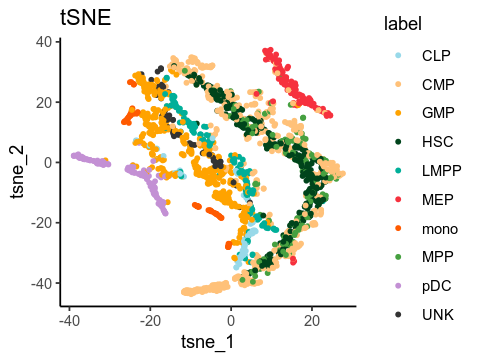

In [28]:
all_color_maps <- c(jdb_color_maps, "UNK" = "#333333" )
options(repr.plot.width=4, repr.plot.height=3)
p <- ggplot(shuf(df_tsne_coords), aes(x = tsne_1, y = tsne_2, color = label)) +
  geom_point(size = 1) + scale_color_manual(values = all_color_maps) +
  ggtitle('tSNE') + theme_classic()
p

In [29]:
data("human.hg19.genome")
genome_ref = human.hg19.genome
file_tss='../../input/hg19/hg19-tss.bed'

In [30]:
head(genome_ref)

V1,V2
chr1,249250621
chr2,243199373
chr3,198022430
chr4,191154276
chr5,180915260
chr6,171115067


In [31]:
row.names(tsne_coords) <- row.names(pData(input_cds))
cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = tsne_coords)
conns <- run_cicero(cicero_cds, genome_ref) # Takes a few minutes to run

Overlap QC metrics:
Cells per bin: 50
Maximum shared cells bin-bin: 44
Mean shared cells bin-bin: 1.39602687700847
Median shared cells bin-bin: 0


[1] "Starting Cicero"
[1] "Calculating distance_parameter value"
[1] "Running models"
[1] "Assembling connections"
[1] "Done"


In [32]:
gene_annotation <- read.table(file_tss,sep='\t')
names(gene_annotation)[4] <- "gene"    
gene_annotation_pos <- subset(gene_annotation, V5 == "+")
gene_annotation_pos$V3 <- gene_annotation_pos$V2 + 1
gene_annotation_neg <- subset(gene_annotation, V5 == "-")
gene_annotation_neg$V2 <- gene_annotation_neg$V3 - 1
tss <- rbind(gene_annotation_pos, gene_annotation_neg)    

In [33]:
input_cds <- annotate_cds_by_site(input_cds, tss)
# generate unnormalized gene activity matrix
unnorm_ga <- build_gene_activity_matrix(input_cds, conns)
unnorm_ga <- unnorm_ga[!Matrix::rowSums(unnorm_ga) == 0,]

# make a list of num_genes_expressed
num_genes <- pData(input_cds)$num_genes_expressed
names(num_genes) <- row.names(pData(input_cds))

# normalize
cicero_gene_activities <- normalize_gene_activities(unnorm_ga, num_genes)    
fm_Cicero = as.matrix(cicero_gene_activities)

In [34]:
end_time <- Sys.time()

In [35]:
end_time - start_time

Time difference of 34.07189 mins

In [36]:
all(colnames(fm_Cicero) == rownames(metadata))

[1] TRUE

In [37]:
saveRDS(fm_Cicero, file = '../../output/feature_matrices/FM_Cicero_buenrostro2018bulkpeaks.rds')

### Downstream Analysis

In [38]:
df_umap_Cicero <- umap(t(fm_Cicero))$layout

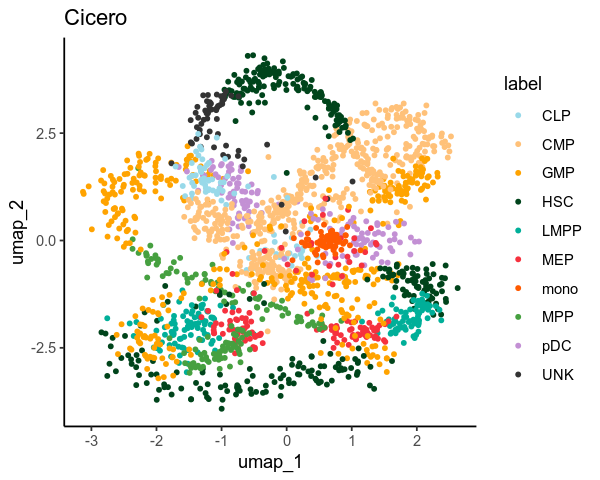

In [39]:
df_umap = data.frame(cbind(df_umap_Cicero,metadata[rownames(pData(input_cds)),'label']),stringsAsFactors = FALSE)
colnames(df_umap) = c('umap_1','umap_2','label')
df_umap$umap_1 = as.numeric(df_umap$umap_1)
df_umap$umap_2 = as.numeric(df_umap$umap_2)
options(repr.plot.width=5, repr.plot.height=4)
p <- ggplot(df_umap, aes(x = umap_1, y = umap_2, color = label)) +
  geom_point(size = 1) + scale_color_manual(values = all_color_maps) +
  ggtitle('Cicero') + theme_classic()
p

In [40]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data/pinello/SHARED_SOFTWARE/anaconda3/envs/ATACseq_Cicero/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      splines   stats4    parallel  stats     graphics  grDevices
 [8] utils     datasets  methods   base     

other attached packages:
 [1] umap_0.2.2.0         BuenColors_0.5.5     MASS_7.3-51.1       
 [4] reshape2_1.4.3       proxy_0.4-23         data.table_1.12.0   
 [7] cicero_1.0.15        Gviz_1.26.5          GenomicRanges_1.34.0
[10] GenomeInfoDb_1.18.1  IR

In [41]:
save.image(file = 'Cicero_buenrostro2018bulkpeaks.RData')